# Fitting a simple model to data using MCMC

An example of using MCMC to fit a straight line to data points, possibly with known individual measurement errors, while accounting for intrinsic scatter and outliers.  The method is easily generalisable to more complicated models and datasets.

We make use of the awesome `emcee` sampler by Dan Foreman-Mackey and collaborators.  Normal `emcee` is contrasted with the parallel-tempered version, and they are shown to give identical results, especially if there is some very light cleaning applied to the normal chains.

This notebook is based on the examples and tutorials provided on [the emcee webpages](http://dan.iel.fm/emcee/), Jake Vanderplas' [wonderful series of blog posts](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), and David Hogg, Jo Bovy and Dustin Lang's insightful [paper on the subject](http://arxiv.org/abs/1008.4686).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import emcee     # install with pip install emcee
import corner  # install with pip install corner
from math import floor

# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [2]:
# define some helper functions

def flatten_without_burn(sampler, nburn):
    c = sampler.chain
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))


def weight_without_burn(sampler, nburn):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


def get_samples(sampler, nburn, minweight=None):
    sample = flatten_without_burn(sampler, nburn)
    if minweight is not None:
        weight = weight_without_burn(sampler, nburn)
        sample = sample[weight > minweight]
    return sample


def minmaxpad(x, p=0.05):
    xmin = x.min()
    xmax = x.max()
    xrange = xmax - xmin
    xmin = xmin - p*xrange
    xmax = xmax + p*xrange
    return xmin, xmax


def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ow', mec='black')

    xmin, xmax = minmaxpad(x)
    dx = (xmax-xmin)/100.0
    xfit = np.linspace(xmin, xmax, 100)
    yfit = model(xfit[...,np.newaxis], trace.T)
    mu = yfit.mean(-1)
    sig = yfit.std(-1)
    
    ax.fill_between(xfit, mu - 2*sig, mu + 2*sig, color='lightgray')
    ax.fill_between(xfit, mu - sig, mu + sig, color='darkgray')
    ax.plot(xfit, mu, '-k')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([xmin, xmax])

    
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None):
    mean = samples.mean(0)
    sigma = samples.std(0)
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        outstr = ('{:16s} = {:8.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr)

In [3]:
# same data as last week
x = np.array([ 1,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 47, 54, 56, 67, 69, 72, 88])

y = np.array([33, 68, 34, 34, 37, 65, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])

e = np.array([3.6, 3.9, 2.6, 3.4, 3.8, 14.8, 2.2, 2.1, 2.3, 3.8,
              2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

In [4]:
meanx = x.mean()
print('meanx = {}'.format(meanx))

meanx = 37.15


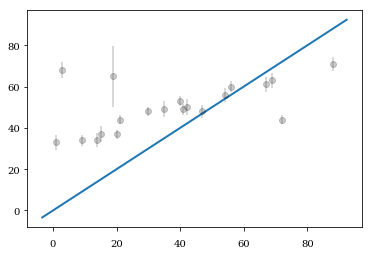

In [5]:
# check the data
xmin, xmax = minmaxpad(x)
plt.errorbar(x, y, e, fmt='ok', alpha=0.2)
_ = plt.plot([xmin, xmax], [xmin, xmax], lw=2)

In [6]:
# define all aspects of the model

xcentre = 14.2

def model(x, theta):
    intercept, slope, scatter, prob_outlier = theta
    return intercept + slope * (x - xcentre)

def log_prior(theta):
    intercept, slope, scatter, prob_outlier = theta
    # scatter must be greater than zero
    if scatter <= 0:
        return -np.inf
    # prob_outlier must be between zero and one
    if prob_outlier < 0 or prob_outlier > 1:
        return -np.inf
    # prior on intercept, slope and scatter; as explained at
    # http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#The-Prior
    # P(intercept) = 1
    # P(slope) = (1 + slope ** 2)^(-1.5)  # uniform in sin(angle)
    # P(scatter) = 1/scatter  # Jeffreys prior, invariant to rescaling
    return -1.5 * np.log(1 + slope ** 2) - np.log(scatter)

# scatter of outlier points, just needs to be much larger than normal scatter
scatter_outliers = 50.0

def log_likelihood(theta, x, y, e, scatter_outliers=scatter_outliers):
    intercept, slope, scatter, prob_outlier = theta
    # square residuals
    y_model = model(x, theta)
    dy2 = (y - y_model)**2
    # avoid NaNs in logarithm
    prob_outlier = np.clip(prob_outlier, 1e-99, 1-1e-99)
    # compute effective variances by combining errors and intrinsic scatter
    eff_var = scatter**2 + e**2
    eff_var_outliers = scatter_outliers**2 + e**2
    # logL for good (normal) and bad (outlier) distributions
    logL_good = (np.log(1 - prob_outlier)
                 - 0.5 * np.log(2 * np.pi * eff_var)
                 - 0.5 * dy2 / eff_var)
    logL_bad = (np.log(prob_outlier)
                - 0.5 * np.log(2 * np.pi * eff_var_outliers)
                - 0.5 * dy2 / eff_var_outliers)    
    # using np.logaddexp helps maintain numerical precision
    return np.sum(np.logaddexp(logL_good, logL_bad))

def logl(theta):
    # PT sampler needs us to use global variables
    return log_likelihood(theta, x, y, e, scatter_outliers)

def log_posterior(theta, x, y, e, scatter_outliers=scatter_outliers):
    return log_prior(theta) + log_likelihood(theta, x, y, e, scatter_outliers)

In [7]:
# set up emcee
np.random.seed(666)  # reproducible

par = ('intercept', 'slope', 'scatter', 'prob_outlier')
ndim = len(par)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsamp = 500  # number of MCMC steps to take after burn-in

initial_theta = np.zeros((nwalkers, ndim))
initial_theta[:, :2] = np.random.normal((14, 1.0), 1, (nwalkers, 2))
initial_theta[:, 2:] = np.random.uniform((0.1, 0.1), (1.0, 0.5), (nwalkers, 2))

In [8]:
# perform sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e], threads=1)
r = sampler.run_mcmc(initial_theta, nburn+nsamp)

/usr/local/anaconda/envs/mpags/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


In [9]:
# perform parallel-tempered sampling
ntemps = 5  # number of temperature rungs
sampler_pt = emcee.PTSampler(ntemps, nwalkers, ndim, logl, log_prior, threads=1)
r_pt = sampler_pt.run_mcmc(initial_theta*np.ones((ntemps, nwalkers, ndim)), nburn+nsamp)

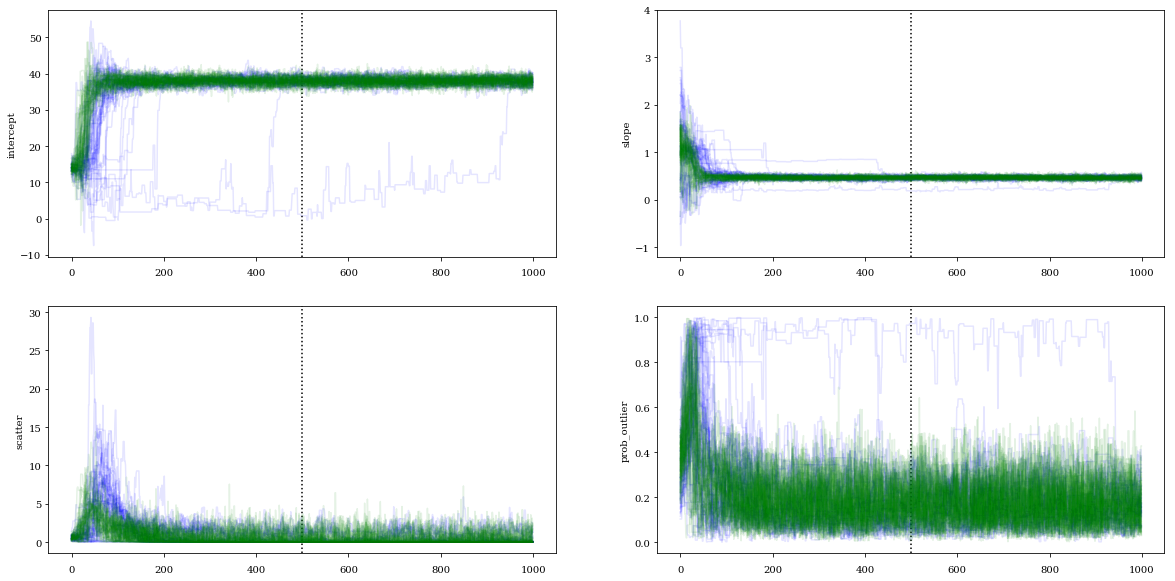

In [10]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot(2,2,i+1)
    for w in range(nwalkers):
        plt.plot(numpy.arange(sampler.chain.shape[1]), sampler.chain[w,:,i], 'b-', alpha=0.1)
    for w in range(nwalkers):
            plt.plot(numpy.arange(sampler_pt.chain.shape[2]), sampler_pt.chain[0,w,:,i], 'g-', alpha=0.1)
    plt.ylabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)

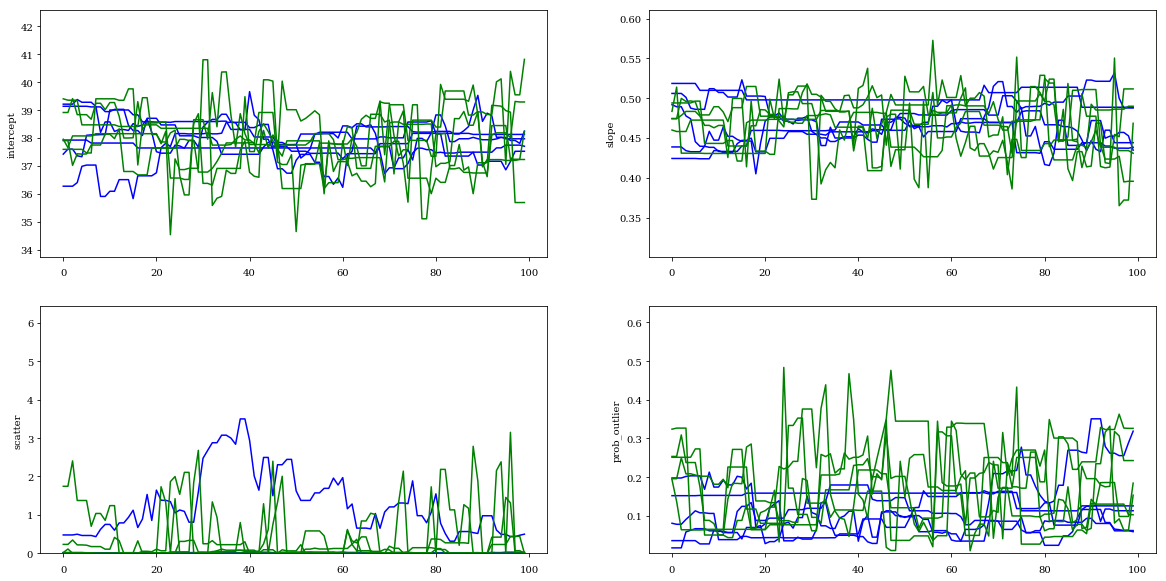

In [11]:
# plot the chains to visually assess auto correlation time at equilibrium
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot(2,2,i+1)
    for w in range(0,nwalkers,10):
        plt.plot(numpy.arange(100), sampler.chain[w,nburn:nburn+100,i], 'b-')
    for w in range(0,nwalkers,10):
            plt.plot(numpy.arange(100), sampler_pt.chain[0,w,nburn:nburn+100,i], 'g-')
    plt.ylabel(p)
    aymin = np.min(sampler_pt.chain[0,:,nburn:,i])
    aymax = np.max(sampler_pt.chain[0,:,nburn:nburn+100,i])
    plt.ylim(aymin, aymax)

In [12]:
# convert chains into samples for each parameter
# clip chains with very low weights for normal method
samples = get_samples(sampler, nburn, minweight=1e-15)
samples_full = get_samples(sampler, nburn)
samples_pt = get_samples(sampler_pt, nburn)

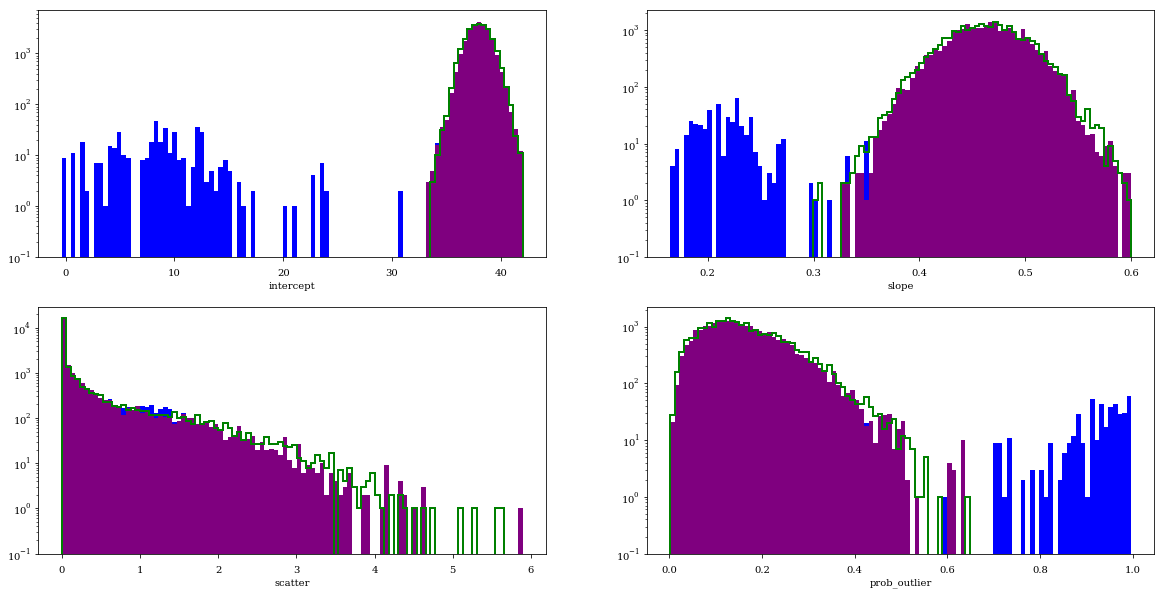

In [13]:
# examine parameter histograms and compare normal and parallel methods
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot(2,(ndim+1)//2,i+1)
    n, b, patches = plt.hist(samples_full[:,i], bins=100, color='b', histtype='stepfilled', log=True)
    plt.hist(samples[:,i], bins=b, color='r', histtype='stepfilled', alpha=0.5)
    plt.hist(samples_pt[:,i], bins=b, color='g', histtype='step', lw=2)
    plt.xlabel(p)

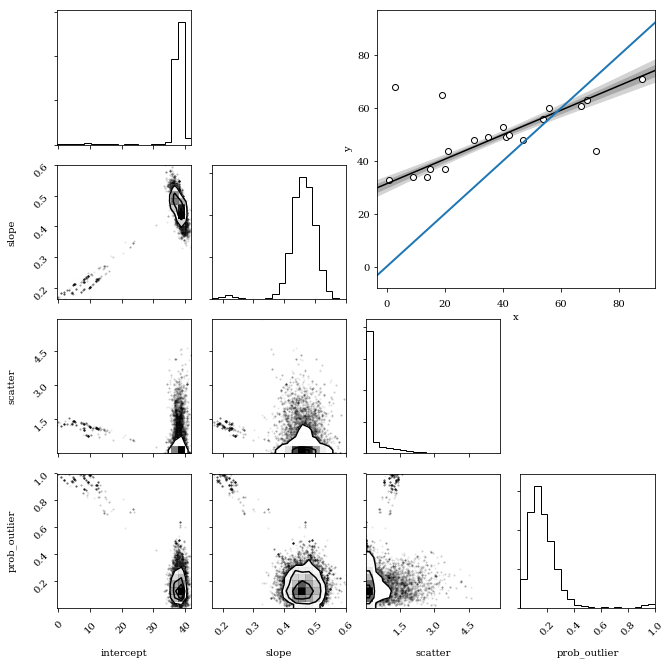

In [14]:
# create mega plot for normal method
corner.corner(samples_full, labels=par)
ax = plt.subplot(2, 2, 2)
plot_MCMC_model(ax, x, y, samples)
plt.plot([xmin, xmax], [xmin, xmax], lw=2)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

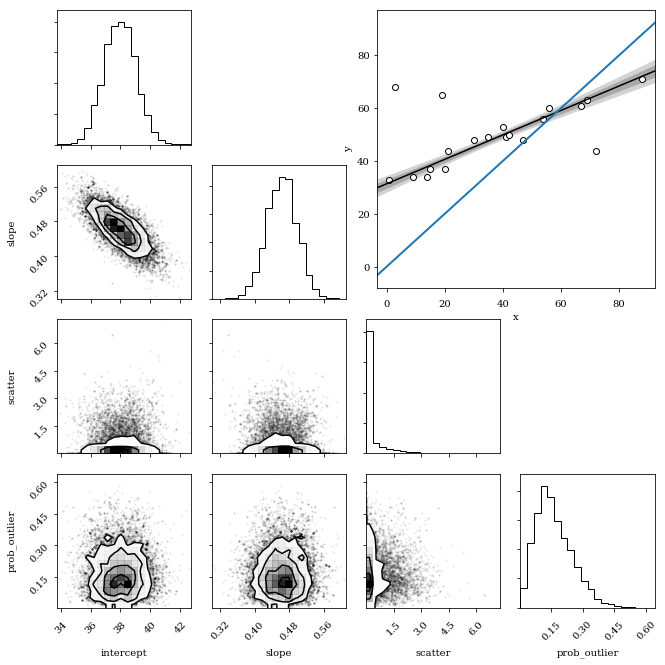

In [15]:
# create mega plot for parallel-tempered method
corner.corner(samples_pt, labels=par)
ax = plt.subplot(2, 2, 2)
plot_MCMC_model(ax, x, y, samples_pt)
plt.plot([xmin, xmax], [xmin, xmax], lw=2)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

In [16]:
# output a summary of the normal results
summary(samples)

intercept        =       38 ± 1       
slope            =     0.46 ± 0.03    
scatter          =      0.3 ± 0.6     
prob_outlier     =     0.16 ± 0.08    


In [17]:
# output a summary of the parallel-tempered results
summary(samples_pt)

intercept        =       38 ± 1       
slope            =     0.46 ± 0.04    
scatter          =      0.3 ± 0.6     
prob_outlier     =     0.16 ± 0.09    
